In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end],series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("Value")
  plt.grid(True)

In [ ]:
def trend(time, slope=0):
  return slope*time

In [ ]:
def seasonal_pattern(season_time):
  return np.where(season_time<0.4,
                  np.cos(season_time*2*np.pi),
                  1/np.exp(3*season_time))

In [ ]:
def seasonality(time, period, amplitude=1, phase=0):
  season_time=((time*phase)%period) / period
  return amplitude * seasonal_pattern(season_time)

In [ ]:
def noise(time,noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [ ]:
time = np.arange(4*365+1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [ ]:
series = baseline + trend(time, slope)+seasonality(time, period=365, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

In [ ]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [ ]:
window_size = 20
batch_sie = 3
shuffle_buffer_size = 1000

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*1000.0)
])

lr_schedule= tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8*10**(epoch/20))

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
  optimizer=optimizer,
  metrics=["mae"])

history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 2s 23ms/step - loss: 2542.7793 - mae: 2543.2793 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 19ms/step - loss: 2431.2312 - mae: 2431.7312 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 2110.1907 - mae: 2110.6907 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 16ms/step - loss: 1649.3807 - mae: 1649.8807 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 1394.6735 - mae: 1395.1735 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 17ms/step - loss: 1211.1543 - mae: 1211.6543 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 17ms/step - loss: 1025.0345 - mae: 1025.5345 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 18ms/step - loss: 819.9615 - mae: 820.4615 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 17ms/step - loss: 58

(1e-08, 0.0001, 0.0, 30.0)

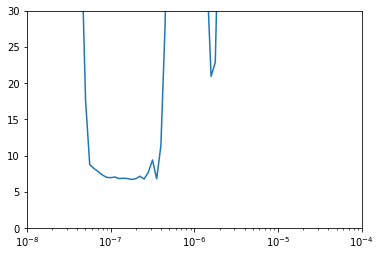

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*1000.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-7, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
  optimizer=optimizer,
  metrics=["mae"])

history = model.fit(train_set, epochs=400)


Epoch 1/400


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 3s 31ms/step - loss: 1518.2008 - mae: 1518.7008
Epoch 2/400
8/8 [==============================] - 0s 16ms/step - loss: 383.3906 - mae: 383.8902
Epoch 3/400
8/8 [==============================] - 0s 16ms/step - loss: 208.6773 - mae: 209.1773
Epoch 4/400
8/8 [==============================] - 0s 18ms/step - loss: 147.9548 - mae: 148.4541
Epoch 5/400
8/8 [==============================] - 0s 16ms/step - loss: 104.7926 - mae: 105.2918
Epoch 6/400
8/8 [==============================] - 0s 17ms/step - loss: 66.2489 - mae: 66.7488
Epoch 7/400
8/8 [==============================] - 0s 15ms/step - loss: 29.2836 - mae: 29.7800
Epoch 8/400
8/8 [==============================] - 0s 17ms/step - loss: 20.1252 - mae: 20.6207
Epoch 9/400
8/8 [==============================] - 0s 16ms/step - loss: 15.9578 - mae: 16.4516
Epoch 10/400
8/8 [==============================] - 0s 18ms/step - loss: 13.8668 - mae: 14.3595
Epoch 11/400
8/8 [==============================]

In [ ]:
# forecast=[]
# for time in range(len(series)- window_size):
#  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

# forecast = forecast[split_time-window_size:]
# results = np.array(forecast[:,0,0])

# plt.figure(figsize=(10,6))

# plot_series(time_valid, x_valid)
# plot_series(time_valid, results)